In [253]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import random
import os

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import *

In [0]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

## **INPUT**

In [256]:
label = pd.read_csv('drive/My Drive/10_Predictive/Pmd_for_Hydro_Plant/data/1_Generator_Stator/5_post_pocessing/classification_label/label_4.csv')
label.index = label['id']
label.drop(('id'), axis=1, inplace=True)
# print(label.head(2))
label.columns = ['datetime','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10',
                 's11','s12','s13','s14','s15','s16','s17','s18','s19','s20',
                 's21','s22','s23','s24','s25','s26','s27']
print(label.shape)
print(label.head(2))
print(label.tail(2))

print("Input")
print("  ")
print("  ")

df = pd.read_csv('drive/My Drive/10_Predictive/Pmd_for_Hydro_Plant/data/1_Generator_Stator/5_post_pocessing/input/INPUT.csv')
df.index = df['id']
df.drop(('id'), axis=1, inplace=True)
print(df.shape)
print(df.head(2))
print(df.tail(2))

(141563, 28)
               datetime  s1  s2  s3  s4  s5  ...  s22  s23  s24  s25  s26  s27
id                                           ...                              
1   2019-04-15 03:41:52   0   0   0   0   0  ...    0    0    0    0    0    0
2   2019-04-15 03:42:52   0   0   0   0   0  ...    0    0    0    0    0    0

[2 rows x 28 columns]
                   datetime  s1  s2  s3  s4  s5  ...  s22  s23  s24  s25  s26  s27
id                                               ...                              
146547  2020-05-10 12:35:11   0   0   0   0   0  ...    0    0    0    0    0    0
146548  2020-05-10 12:40:07   0   0   0   0   0  ...    0    0    0    0    0    0

[2 rows x 28 columns]
Input
  
  
(141484, 31)
                      0    1    2    3  ...      27        28        29        30
id                                      ...                                      
1   2019-04-15 03:41:52  0.0  0.0  0.0  ...  43.895  35.29915  44.00244  35.83639
2   2019-04-15 03:42:5

In [257]:
df_concat = pd.concat([df, label], axis=1, sort=False)
df_concat.dropna(inplace=True)
df_concat.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,datetime,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23,s24,s25,s26,s27
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2019-04-15 03:41:52,0.0,0.0,0.0,0.9375,27.56288,25.73627,43.57265,35.51404,43.57265,35.40659,43.57265,35.51404,43.78754,35.51404,44.32478,35.40659,43.78754,35.51404,43.6801,35.40659,43.6801,35.40659,43.895,35.62149,44.10989,35.72894,43.895,35.29915,44.00244,35.83639,2019-04-15 03:41:52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2019-04-15 03:42:52,0.0,0.0,0.0,0.9375,27.56288,25.73627,43.57265,35.51404,43.57265,35.40659,43.57265,35.51404,43.78754,35.51404,44.32478,35.40659,43.78754,35.51404,43.6801,35.40659,43.6801,35.40659,43.895,35.62149,44.10989,35.72894,43.895,35.29915,44.00244,35.83639,2019-04-15 03:42:52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [258]:
df = df_concat.iloc[:,:31]
print(df.head(2))
print(df.tail(2))
label = df_concat.iloc[:,31:]
print(label.head(2))
print(label.tail(2))

                      0    1    2    3  ...      27        28        29        30
id                                      ...                                      
1   2019-04-15 03:41:52  0.0  0.0  0.0  ...  43.895  35.29915  44.00244  35.83639
2   2019-04-15 03:42:52  0.0  0.0  0.0  ...  43.895  35.29915  44.00244  35.83639

[2 rows x 31 columns]
                          0       1        2  ...        28        29        30
id                                            ...                              
146532  2020-05-10 02:39:45  83.034 -9.41052  ...  32.93529  51.63126  34.65446
146533  2020-05-10 02:44:33   0.000  0.00000  ...  32.61295  51.63126  34.65446

[2 rows x 31 columns]
               datetime  s1  s2  s3  s4  s5  ...  s22  s23  s24  s25  s26  s27
id                                           ...                              
1   2019-04-15 03:41:52   0   0   0   0   0  ...    0    0    0    0    0    0
2   2019-04-15 03:42:52   0   0   0   0   0  ...    0    0    0    0 

In [259]:
print(df.shape[0]%288)
part = df.shape[0]%288
df = df.iloc[part:,:]
label = label.iloc[part:,:]
print(df.shape)

76
(141408, 31)


In [260]:
df = df.iloc[:,1:].values.reshape(-1,288,30).transpose(0,1,2)
print(df.shape)
label = label.iloc[:,1:].values.reshape(-1,288,27).transpose(0,1,2)
label = np.max(label, axis = 1)
label = pd.DataFrame(label,columns=["s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8", "s9", "s10", "s11", "s12", "s13","s14",
                             "s15", "s16", "s17", "s18", "s19", "s20", "s21", "s22", "s3", "s24", "s25", "s26", "s27"])
print(label.shape)
print(type(label))

(491, 288, 30)
(491, 27)
<class 'pandas.core.frame.DataFrame'>


In [261]:
label = label.s14
label.value_counts()

0    489
1      2
Name: s14, dtype: int64

In [262]:
### MAPPING LABEL ###
diz_label, diz_reverse_label = {}, {}
for i,lab in enumerate(label.unique()):
    diz_label[lab] = i
    diz_reverse_label[i] = lab

print(diz_label)
print(diz_reverse_label)
label = label.map(diz_label)
y = to_categorical(label)

{0: 0, 1: 1}
{0: 0, 1: 1}


In [263]:
y.shape

(491, 2)

In [0]:
### TRAIN TEST SPLIT ###

X_train, X_test, y_train, y_test = train_test_split(df, y, random_state = 42, test_size=0.2)

In [0]:
### SCALE DATA ###

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [266]:
num_sensors = 30
TIME_PERIODS = 288
BATCH_SIZE = 16
EPOCHS = 10

model_m = Sequential()
model_m.add(Conv1D(100, 6, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(100, 6, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 6, activation='relu'))
model_m.add(Conv1D(160, 6, activation='relu'))
model_m.add(GlobalAveragePooling1D(name='G_A_P_1D'))
model_m.add(Dropout(0.5))
model_m.add(Dense(2, activation='softmax'))

model_m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_m.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, verbose=2)

Epoch 1/10
20/20 - 0s - loss: 0.3004 - accuracy: 0.9681 - val_loss: 5.2902e-04 - val_accuracy: 1.0000
Epoch 2/10
20/20 - 0s - loss: 0.0319 - accuracy: 0.9968 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 3/10
20/20 - 0s - loss: 0.0290 - accuracy: 0.9968 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 4/10
20/20 - 0s - loss: 0.0148 - accuracy: 0.9968 - val_loss: 2.0371e-07 - val_accuracy: 1.0000
Epoch 5/10
20/20 - 0s - loss: 0.1671 - accuracy: 0.9968 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 6/10
20/20 - 0s - loss: 0.0209 - accuracy: 0.9968 - val_loss: 1.2931e-06 - val_accuracy: 1.0000
Epoch 7/10
20/20 - 0s - loss: 0.1601 - accuracy: 0.9968 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 8/10
20/20 - 0s - loss: 0.0133 - accuracy: 0.9968 - val_loss: 1.7332e-04 - val_accuracy: 1.0000
Epoch 9/10
20/20 - 0s - loss: 0.0224 - accuracy: 0.9968 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 10/10
20/20 - 0s - loss: 0.0113 - accuracy: 0.9968 - val_loss: 6.1345e-04 - val_accuracy: 1.0000

In [267]:
model_m.evaluate(X_test, y_test, verbose=2)

4/4 - 0s - loss: 0.1136 - accuracy: 0.9899


[0.11361614614725113, 0.9898989796638489]

In [0]:
### GET PREDICTED CLASS ###

pred_test = np.argmax(model_m.predict(X_test), axis=1)

In [269]:
print(classification_report([diz_reverse_label[np.argmax(label)] for label in y_test], 
                            [diz_reverse_label[label] for label in pred_test]))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        98
           1       0.00      0.00      0.00         1

    accuracy                           0.99        99
   macro avg       0.49      0.50      0.50        99
weighted avg       0.98      0.99      0.98        99



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


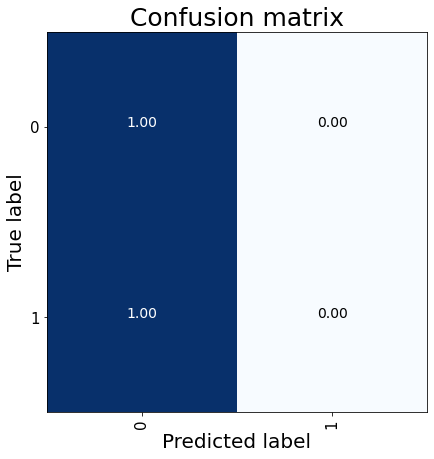

In [270]:
cnf_matrix = confusion_matrix([diz_reverse_label[np.argmax(label)] for label in y_test], 
                              [diz_reverse_label[label] for label in pred_test])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_reverse_label.values()))
plt.show()

In [271]:
### MAKE A MODEL FOR EMBEDDINGS ###
emb_model = Model(inputs=model_m.input, outputs=model_m.get_layer('G_A_P_1D').output)
emb_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20_input (InputLayer) [(None, 288, 30)]         0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 283, 100)          18100     
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 278, 100)          60100     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 92, 100)           0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 87, 160)           96160     
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 82, 160)           153760    
_________________________________________________________________
G_A_P_1D (GlobalAveragePooli (None, 160)               0   

In [0]:
### EXTRACT EMBEDDINGS ###
# serie_features = emb_model.predict(X_test)
serie_features = emb_model.predict(X_train)

In [273]:
serie_features.shape

(392, 160)

In [0]:
### VISUALIZE EMBEDDINGS ###
tsne = TSNE(n_components=2, random_state=42, n_iter=300, perplexity=5)
T = tsne.fit_transform(serie_features)

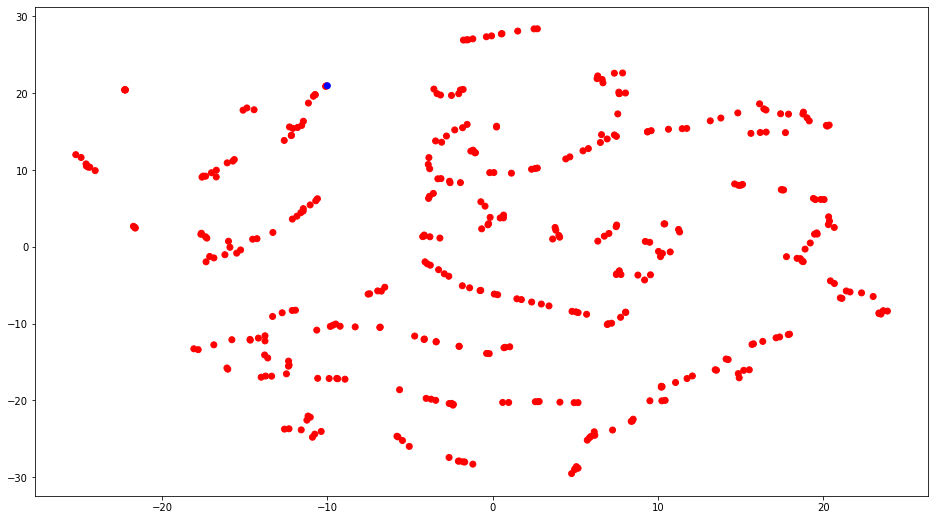

In [275]:
plt.figure(figsize=(16,9))
colors = {0:'red', 1:'blue', 2:'yellow'}
# plt.scatter(T.T[0], T.T[1], c=[colors[i] for i in np.argmax(y_test, axis=1)]) 
plt.scatter(T.T[0], T.T[1], c=[colors[i] for i in np.argmax(y_train, axis=1)])
plt.show()